run the filterPairTGapsMetric, save the output as csv file. 
take several hours to run for all opsims

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

import healpy as hp
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db


In [2]:
# load opsim database
dbpath = "/home/idies/workspace/lsst_cadence/FBS_1.4/"  # path to all opsim databases

# output directory
outDir = 'outDir'
resultsDb = db.ResultsDb(outDir=outDir)


In [3]:
# get the name of all opsim dbs 
import glob

os.chdir(dbpath)  # change to opsim database directory
dblist_all = glob.glob('*.db') 
workpath = '/home/idies/workspace/Storage/lixl/persistent/LSST_OpSim/unknowns'
os.chdir(workpath) # change back to work directory
dblist_all.sort()

In [9]:
dblist_all

['agnddf_v1.4_10yrs.db',
 'alt_roll_mod2_dust_sdf_0.20_v1.4_10yrs.db',
 'baseline_2snapsv1.4_10yrs.db',
 'baseline_v1.4_10yrs.db',
 'bulges_bs_v1.4_10yrs.db',
 'bulges_bulge_wfd_v1.4_10yrs.db',
 'bulges_cadence_bs_v1.4_10yrs.db',
 'bulges_cadence_bulge_wfd_v1.4_10yrs.db',
 'bulges_cadence_i_heavy_v1.4_10yrs.db',
 'bulges_i_heavy_v1.4_10yrs.db',
 'dcr_nham1_v1.4_10yrs.db',
 'dcr_nham2_v1.4_10yrs.db',
 'dcr_nham3_v1.4_10yrs.db',
 'dcr_nham4_v1.4_10yrs.db',
 'dcr_nham5_v1.4_10yrs.db',
 'descddf_v1.4_10yrs.db',
 'euclidddf_v1.4_10yrs.db',
 'footprint_add_mag_cloudsv1.4_10yrs.db',
 'footprint_big_sky_dustv1.4_10yrs.db',
 'footprint_big_sky_nouiyv1.4_10yrs.db',
 'footprint_big_skyv1.4_10yrs.db',
 'footprint_bluer_footprintv1.4_10yrs.db',
 'footprint_gp_smoothv1.4_10yrs.db',
 'footprint_newAv1.4_10yrs.db',
 'footprint_newBv1.4_10yrs.db',
 'footprint_no_gp_northv1.4_10yrs.db',
 'footprint_standard_goalsv1.4_10yrs.db',
 'footprint_stuck_rollingv1.4_10yrs.db',
 'pair_strategy_0_v1.4_10yrs.db',
 

In [10]:
import time 
time.asctime( time.localtime(time.time()) )

'Mon Jun 29 08:47:53 2020'

In [3]:
#dbname="baseline_v1.4_10yrs.db"
#dbname="pair_strategy_0_v1.5_10yrs.db"
dbname = "sat_dodge_v1.4_10yrs.db"
opsdb = db.OpsimDatabase(dbpath+dbname)


In [4]:
opsdb.fetchPropInfo() # view proposal information

No proposal table available - no proposalIds have been assigned.


({}, {})

In [5]:
opsdb.columnNames  # view available column names

{'SummaryAllProps': ['observationId',
  'fieldRA',
  'fieldDec',
  'observationStartMJD',
  'flush_by_mjd',
  'visitExposureTime',
  'filter',
  'rotSkyPos',
  'numExposures',
  'airmass',
  'seeingFwhm500',
  'seeingFwhmEff',
  'seeingFwhmGeom',
  'skyBrightness',
  'night',
  'slewTime',
  'visitTime',
  'slewDistance',
  'fiveSigmaDepth',
  'altitude',
  'azimuth',
  'paraAngle',
  'cloud',
  'moonAlt',
  'sunAlt',
  'note',
  'fieldId',
  'proposalId',
  'block_id',
  'observationStartLST',
  'rotTelPos',
  'moonAz',
  'sunAz',
  'sunRA',
  'sunDec',
  'moonRA',
  'moonDec',
  'moonDistance',
  'solarElong',
  'moonPhase'],
 'info': ['index', 'Parameter', 'Value']}

In [6]:
class filterPairTGapsMetric(metrics.BaseMetric):
    """
    returns all observation visits between two filters
    """

    def __init__(self, colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'], 
                 filename='dT.pkl', fltpair=['y','i'],
                 dataout=True, **kwargs):
        self.colname = colname
        self.filename = filename
        self.fltpair = fltpair
        self.dataout = dataout
                
        self.Nrun = 0
        if os.path.isfile(filename):
            # rm old file
            os.system("rm {}".format(filename))
        
        if self.dataout:
            super().__init__(col=self.colname, metricDtype='object', **kwargs)
        else:
            super().__init__(col=self.colname, metricDtype='float', **kwargs)

#    def dT(self, dataSlice, f0='i', f1='r'):
#        ''' return an array that contains all time gaps between two filters'''
#        idx0 = dataSlice['filter'] == f0
#        idx1 = dataSlice['filter'] == f1
#        
#        timeCol0 = dataSlice['observationStartMJD'][idx0]
#        timeCol1 = dataSlice['observationStartMJD'][idx1]
#
#        timeCol0 = timeCol0.reshape((len(timeCol0), 1))
#        timeCol1 = timeCol1.reshape((len(timeCol1), 1))
        
        #diffmat = np.abs( np.subtract(timeCol0, timeCol1.T) )

        #return diffmat.flatten(), timeCol0, timeCol1

    
#    def load_from_pkl(self, filename="test_pkl.pkl"):
#        '''load dataframe from pickle'''
#        if os.path.isfile(filename):
#            df = pd.read_pickle(filename)
#        else:
#            df = pd.DataFrame()
#            df.to_pickle(filename)
#        return df
    
    def save_to_file(self, dic, filename="test_pkl.pkl"):
        '''save dict item to pickle file'''
        
        #df = self.load_from_pkl(filename)

        #df = df.append(pd.DataFrame(dic), ignore_index=True)

        #df.to_pickle(filename)
        df = pd.DataFrame(dic)
        with open(filename, 'a') as f:
            df.to_csv(f, header=f.tell()==0, index=None)
    
    def run(self, dataSlice, slicePoint=None):
        # sort dataSlice
        flt = ['u', 'g', 'r', 'i', 'z', 'y']
        fdict = {'u':0, 'g':1, 'r':2, 'i':3, 'z':4, 'y':5}

        dataSlice.sort(order='observationStartMJD')
        
        #dT, t_f0, t_f1 = self.dT(dataSlice, f0=self.fltpair[0], f1=self.fltpair[1])
        #print( self.fltpair )
        
        #print(type(dataSlice['fieldRA']), dataSlice['fieldDec'])
        #dT_list = []
        #for i in range(len(dataSlice['fieldRA'])):
        #   dT_list.append(dT)
        
        # dic = {'ra':np.mean(dataSlice['fieldRA']), 'dec':np.mean(dataSlice['fieldDec']), 'dT': [dT]}
        # dic = {'ra':np.mean(dataSlice['fieldRA']), 
        #      'dec':np.mean(dataSlice['fieldDec']), 
        #       'dT': [dT], 
        #      'f0': self.fltpair[0], 
        #       'f1':self.fltpair[1],
        #       't_f0': [t_f0.flatten()],
        #       't_f1': [t_f1.flatten()]
        #      }
        self.Nrun +=1     # record number of field
        
        for i, f0 in enumerate(flt):
            for f1 in flt[i:]:
                idx0 = dataSlice['filter'] == f0
                idx1 = dataSlice['filter'] == f1
                
                timeCol0 = dataSlice['observationStartMJD'][idx0]
                timeCol1 = dataSlice['observationStartMJD'][idx1]
                
                fiveSigmaCol0 = dataSlice['fiveSigmaDepth'][idx0]
                fiveSigmaCol1 = dataSlice['fiveSigmaDepth'][idx1]
        
                dic = {'field': self.Nrun, 
                       'proposalId': np.mean( dataSlice['proposalId'] ), 
                       'ra': np.mean(dataSlice['fieldRA']), 
                       'dec': np.mean(dataSlice['fieldDec']), 
                       'f0': f0,
                       'f1': f1,
                       't_f0': [timeCol0],
                       't_f1': [timeCol1],
                       'fiveSigma_f0': [fiveSigmaCol0],
                       'fiveSigma_f1': [fiveSigmaCol1],
                      }
                
                #dic = {'field': self.Nrun, 
                #       'proposalId_f0': [ dataSlice['proposalId'][idx0] ], 
                #       'proposalId_f1': [ dataSlice['proposalId'][idx1] ],
                #       'note_f0': [ dataSlice['note'][idx0] ], 
                #       'note_f1': [ dataSlice['note'][idx1] ],
                #       'ra_f0': [ dataSlice['fieldRA'][idx0] ], 
                #       'dec_f0':[ dataSlice['fieldDec'][idx0] ], 
                #       'ra_f1': [ dataSlice['fieldRA'][idx1] ], 
                #       'dec_f1':[ dataSlice['fieldDec'][idx1] ],        
                #       'f0': f0,
                #       'f1': f1,
                #       't_f0': [timeCol0],
                #       't_f1': [timeCol1],
                #       'fiveSigma_f0': [fiveSigmaCol0],
                #       'fiveSigma_f1': [fiveSigmaCol1],
                #        }
                
            # print(dic)
            # save to file
                self.save_to_file(dic, self.filename)
                #print('field', self.Nrun,  dic['ra'], dic['dec'], f0, f1)
        #print('field', self.Nrun)
        
        # return dT
        if self.dataout:
            result = dic
            return result
        else:
        #    f0 = self.fltpair[0]
        #    f1 = self.fltpair[1]
            dT = timeCol0       # not correct, for test only
            result = np.min(dT) if len(dT)!=0 else np.inf
            return float(result)


In [7]:
def runAllPair(dbname="baseline_v1.4_10yrs.db", nside=8, sqlstr='night<400', savepath='data/'):
    '''create a metric dict and run for all filter pairs'''
    
    dbname = dbname  # name of opsim database
    opsdb = db.OpsimDatabase(dbpath+dbname)
    
    slicer = slicers.HealpixSlicer(nside=nside)
    
    # create an dict to run metric for metricBundles
    metricSkyDict = {}
    #if DD:
    #   sqlstr += ' and note like "DD%"' # (cosider only DDFs)

    #    filename = 'data/tFilter_{}_nside{}_DD.csv'.format(dbname, nside)
    #else:
    #    sqlstr += ' and note not like "DD%"' # (remove DDFs)

    #   filename = 'data/tFilter_{}_nside{}_noDD.csv'.format(dbname, nside)
    
    # filename = '{}/tGaps_{}_nside{}_{}_mag_note'.format(savepath, dbname, nside, sqlstr)
    filename = '{}/tGaps_{}_nside{}_{}_mag'.format(savepath, dbname, nside, sqlstr)
    metric = filterPairTGapsMetric(colname=['observationStartMJD', 'filter', 'proposalId', 'fiveSigmaDepth', 'note'], 
                              filename=filename, dataout=True)
    
    metricSky = metricBundles.MetricBundle(metric,slicer,sqlstr)
    metricSkyname = 'metricSky'
    metricSkyDict[metricSkyname] = metricSky
    group = metricBundles.MetricBundleGroup(metricSkyDict, opsdb, outDir=outDir, resultsDb=resultsDb)
    
    print("> get observation time for all pairs of ", dbname)
    group.runAll()


In [14]:
dblist_all[40:41]

['sat_dodge_v1.4_10yrs.db']

In [15]:
%%time
# no deep drilling field 
# proposalId=1 for WFD
# note like "DD%" for five DDF
for dbname in dblist_all[40:41]:
    runAllPair(dbname=dbname, nside=16, sqlstr='note not like "DD%" ',
               savepath='/home/idies/workspace/Temporary/lixl/scratch')  # run for all ten years
    
    with open('filterPairTGaps_v1.4_mag', 'a') as f:
        lctime = time.asctime( time.localtime(time.time()) )
        f.write('finished run {} {}\n'.format(dbname, lctime) )


Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
> get observation time for all pairs of  sat_dodge_v1.4_10yrs.db
Querying database SummaryAllProps with constraint note not like "DD%"  for columns ['observationStartMJD', 'fieldDec', 'fieldRA', 'fiveSigmaDepth', 'filter', 'note', 'proposalId']
Found 1953444 visits
Running:  ['metricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
CPU times: user 11min 36s, sys: 33 s, total: 12min 9s
Wall time: 16min 41s


-----

time gaps

In [4]:
def to_array(x):
    '''converters to convert csv string to numpy array, used to load csv file'''
    arrstr = x.replace('[','').replace(']', '')
    arr = np.fromstring(arrstr, sep=' ')
    return arr


In [5]:
def cal_diffmat(df, night=[0, 400]):
    '''calculate time gaps matrix from visit timeCol of two filters, between night[0]~night[1]'''
    # # check start MJD is same as in the database
    startMJD = 59853.985644 + night[0]
    endMJD = 59853.985644 + night[1]
    t_f0 = df['t_f0'] [ (df['t_f0']>=startMJD) & (df['t_f0']<=endMJD) ]
    t_f1 = df['t_f1'] [ (df['t_f1']>=startMJD) & (df['t_f1']<=endMJD) ]
    
    t_f0 = t_f0.reshape((len(t_f0), 1))
    t_f1 = t_f1.reshape((len(t_f1), 1))
    
    diffmat = np.abs( np.subtract(t_f0, t_f1.T) )
    
    return diffmat

In [6]:
def cal_dT(df):
    '''collect all time gaps'''
    
    if df.f0==df.f1:
        # get only triangle part
        dt_tri = np.tril(df['diffmat'], -1)
        dT = dt_tri[dt_tri!=0]    # flatten lower triangle 

    else:
        dT = df['diffmat'].flatten()
    
    return dT


In [7]:
def KL_div(px, qx):
    '''calculate KL divergences D(P||Q)'''
    kl = np.sum( px * np.log(px / qx) )
    return kl


In [8]:
def get_Dkl(values):
    '''kl divergence for histogram'''
    if values.any():
        values = values + 0.00001  # make each element non-zero
        prob = (values) / values.sum()  
    
        prob_uni = np.ones( len(prob) ) / len(prob)
        return KL_div(prob_uni, prob) 
    
    else:
        return np.NaN
        

In [9]:
def get_hist_dict(dbfile='', path='', night=[0,400], 
                  tmin=[0, 0], tmax=[1.5, 1.5], 
                  histbins=[20, 20] ):
    """
    get histogram values for each filter pair, return dict, 
    tmin, tmax, histbins[0] for same filter, 
    tmin, tmax, histbins[1] for different filter
    """
    
    filename = path + dbfile
    df_all = pd.read_csv(filename, 
                 converters={'t_f0':to_array, 't_f1':to_array})
    
    print('loaded ', filename)

    # calculate dT
    df_all['diffmat'] = df_all.apply(cal_diffmat, axis=1, night=night)
    df_all['dT'] = df_all.apply(cal_dT, axis=1)
    
    flt = ['u', 'g', 'r', 'i', 'z', 'y']

    filter_dict = {} 
    for i, f0 in enumerate(flt):
        for f1 in flt[i:]:
            # filename = 'data/tFilter_{}{}_{}.pkl'.format(f0, f1, dbname)
            #df = pd.read_pickle(filename)
            df = df_all[ (df_all['f0']==f0) & (df_all['f1']==f1) ].copy()
            
            f0f1 = '{}{}'.format(f0,f1)
            filter_dict[ f0f1 ] = {}
            #axs[fdict[f0], fdict[f1]].hist(dT[dT<1/24],bins=100); 
            if f0==f1:
                # concatenate dT
                #df['diffmat'] = df.apply(cal_diffmat, axis=1)
                #df['dT'] = df.apply(cal_dT, axis=1)
                
                dT = np.concatenate(df['dT'].values) * 24
                
                dT_tlim = dT[(dT>tmin[0])&(dT<tmax[0])] 
                Ntotal = len(dT_tlim)

                values, bins_ = np.histogram(dT_tlim, bins=histbins[0]);
                                
                filter_dict[ f0f1 ]['dT'] = dT_tlim
                filter_dict[ f0f1 ]['values'] = values
                filter_dict[ f0f1 ]['bins'] = bins_
                filter_dict[ f0f1 ]['Nv'] = len(dT_tlim)
                filter_dict[ f0f1 ]['Dkl'] = get_Dkl( values )
                filter_dict[ f0f1 ]['eDkl'] = np.exp(- get_Dkl( values ) )
                
            else:
      
                #df['diffmat'] = df.apply(cal_diffmat, axis=1)
                #df['dT'] = df.apply(cal_dT, axis=1)
                
                dT = np.concatenate(df['dT'].values) * 24   # convert to hour
                
                dT_tlim = dT[(dT>tmin[1])&(dT<tmax[1])]

    
                Ntotal = len(dT_tlim)
        
                values, bins_ = np.histogram(dT_tlim, bins=histbins[1] );

                # save to dict 
                filter_dict[ f0f1 ]['dT'] = dT_tlim
                filter_dict[ f0f1 ]['values'] = values
                filter_dict[ f0f1 ]['bins'] = bins_
                filter_dict[ f0f1 ]['Nv'] = len(dT_tlim)
                filter_dict[ f0f1 ]['Dkl'] = get_Dkl( values )
                filter_dict[ f0f1 ]['eDkl'] = np.exp(- get_Dkl( values ) )
    
    return filter_dict


In [10]:
def plot_hist(filter_dict, histbins=[50, 50], **kwargs):
    """plot histogram"""
    fig, axs = plt.subplots(6, 6, figsize=(20, 20), constrained_layout=True); # 6 axes on a 2x3 grid
    flt = ['u', 'g', 'r', 'i', 'z', 'y']
    fdict = {'u':0, 'g':1, 'r':2, 'i':3, 'z':4, 'y':5}
    
    for i, f0 in enumerate(flt):
        for f1 in flt[i:]:
            key = '{}{}'.format(f0, f1)
            dT = filter_dict[key] ['dT']
            eDkl = filter_dict[key] ['eDkl']
                        
            if f0==f1:
                ax = axs[fdict[f0], fdict[f1]]
                # plot a uniform distribution
                if len(dT)!=0:
                    values, bins, _ = ax.hist(dT, bins=histbins[0], **kwargs );
                    
                    
                    low = np.log(dT.min())
                    high = np.log(dT.max())
                    uni = np.power(10, np.random.uniform(low=low, high=high, size=len(dT) ) )
                    _ = ax.hist(uni, bins=histbins[0], **kwargs );
                
                ax.set_xscale("log")
    
            else:
            
                axs[fdict[f0], fdict[f1]].axis('off')
                ax = axs[fdict[f1], fdict[f0]]
                
                # plot a uniform distribution
                if len(dT)!=0:
                    values, bins, _ = ax.hist(dT, bins=histbins[1], **kwargs );

                    uni = np.random.uniform(low=dT.min(), high=dT.max(), size=len(dT) )

                    _ = ax.hist(uni, bins=histbins[1], **kwargs );
                
            #values, bins, _ = ax.hist(dT, **kwargs );
            
            title = '{}{} Nv={} $D_k$={:.2f}'.format(f0, f1, len(dT), filter_dict[key] ['Dkl'])
            ax.set_title(title)
    
            #ax.set_xlabel('Nvisits')
            #ax.set_ylabel('N fields')


In [114]:
def plot_hist_colorbar(filter_dict, figsize=(20, 20), histbins=[50, 50], vmax=10000, **kwargs):
    """plot histogram"""
    #fig, axs = plt.subplots(6, 6, figsize=figsize, constrained_layout=True); # 6 axes on a 2x3 grid
    fig, axs = plt.subplots(6, 6, figsize=figsize, constrained_layout=True);
    flt = ['u', 'g', 'r', 'i', 'z', 'y']
    fdict = {'u':0, 'g':1, 'r':2, 'i':3, 'z':4, 'y':5}
    cmap = matplotlib.cm.OrRd
    for i, f0 in enumerate(flt):
        for f1 in flt[i:]:
            key = '{}{}'.format(f0, f1)
            dT = filter_dict[key] ['dT']
            eDkl = filter_dict[key] ['eDkl']
            
            #title = '{}{} Nv={} $D_k$={:.2f}'.format(f0, f1, len(dT), filter_dict[key] ['Dkl'])                   
            dkltex = '$D_{KL}$'
            title = '{} {}={:.2f}'.format(key, dkltex, filter_dict[key] ['Dkl'])

            if f0==f1:
                vmin1 = 100000
                vmax1 = 30000000
                norm = matplotlib.colors.Normalize(vmin=vmin1, vmax=vmax1)
                m1 = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
                
                ax = axs[fdict[f0], 5]
                axs[fdict[f0], fdict[f1]].axis('off')
                # plot distribution
                Nv = len(dT)
                if Nv!=0:
                    values, bins, _ = ax.hist(dT, bins=histbins[0], color=m1.to_rgba(Nv), label=title, **kwargs );
                    ax.legend(loc='upper center', handlelength=0, handletextpad=0, frameon=False)
                ax.set_xscale("log")
                
            else:
                axs[fdict[f0], fdict[f1]].axis('off')
                ax = axs[fdict[f1], fdict[f0]]
                
                vmin2 = 0
                vmax2 = 200000
                norm = matplotlib.colors.Normalize(vmin=vmin2, vmax=vmax2)
                m2 = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

                # plot distribution
                Nv = len(dT)
                #if Nv!=0:
                values, bins, _ = ax.hist(dT, bins=histbins[1], color=m2.to_rgba(Nv), label=title, **kwargs );
                ax.legend(loc='upper center', handlelength=0, handletextpad=0, frameon=False)
            
            # ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

            # ax.set_title(title)
            
            if fdict[f1]!=5:
                ax.get_xaxis().set_ticklabels([])
                
            ax.get_yaxis().set_ticks([])
            #ax.set_ylabel('N fields')
            print(key, Nv)
    for i in range(6):
        #axs[i, i].axis('off')
        axs[i, 5].axis('on')    
        axs[5, i].set_xlabel('$\Delta t$ (hours)')
          
    # cbar diagonal
    m1.set_array(np.linspace(vmin1, vmax1) ) 
    cbar1 = fig.colorbar(mappable=m1, ax=axs[:,5], shrink=1, location='bottom')
    cbar1.set_label('Nv')
    #cbar1.formatter.set_powerlimits((0, 0))
    #cbar1.update_ticks()

    # for off diagonal
    m2.set_array(np.linspace(vmin2, vmax2) ) 
    cbar2 = fig.colorbar(mappable=m2, ax=axs[:,:5], shrink=.6, location='bottom')
    cbar2.set_label('Nv')
    cbar2.set_clim([0, vmax2])

    cbar2.formatter.set_powerlimits((0, 0))
    cbar2.update_ticks()
    
    #fig.suptitle(dbfile, fontsize=16)
    #fig.savefig('{}.png'.format(filename), dpi=200)
    #fig.tight_layout( pad=1.0 )


In [68]:
%%time
# 5 sec to 10yrs(~3e8)
bins_log=np.logspace(np.log10(5/60/60), np.log10(3e8/60./60.), 50)

dbfile = 'tGaps_baseline_v1.4_10yrs.db_nside16_proposalId=1.csv'
#dbfile = 'tGaps_sat_dodge_v1.4_10yrs.db_nside16_note not like "DD%" _mag'
path = '/home/idies/workspace/Temporary/lixl/scratch/'
filter_dict = get_hist_dict(dbfile=dbfile, path=path , night=[0, 4000], 
                  tmin=[5/60/60, 5/60/60], tmax=[4000*24, 1.5], histbins=[bins_log, 50])  


loaded  /home/idies/workspace/Temporary/lixl/scratch/tGaps_baseline_v1.4_10yrs.db_nside16_proposalId=1.csv
CPU times: user 1min 29s, sys: 4.22 s, total: 1min 34s
Wall time: 1min 34s


In [21]:
plt.rcParams

/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-7, 7],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.f

In [44]:
plt.rcParams['legend.fontsize'] = 16

plt.rcParams['axes.labelsize'] = 12

uu 2350946
ug 20446
ur 8260
ui 1631
uz 0
uy 10
gg 4319998
gr 141713
gi 22586
gz 2766
gy 823
rr 25073142
ri 156999
rz 24350
ry 2288
ii 25454405
iz 186503
iy 24135
zz 20729265
zy 126901
yy 22471448


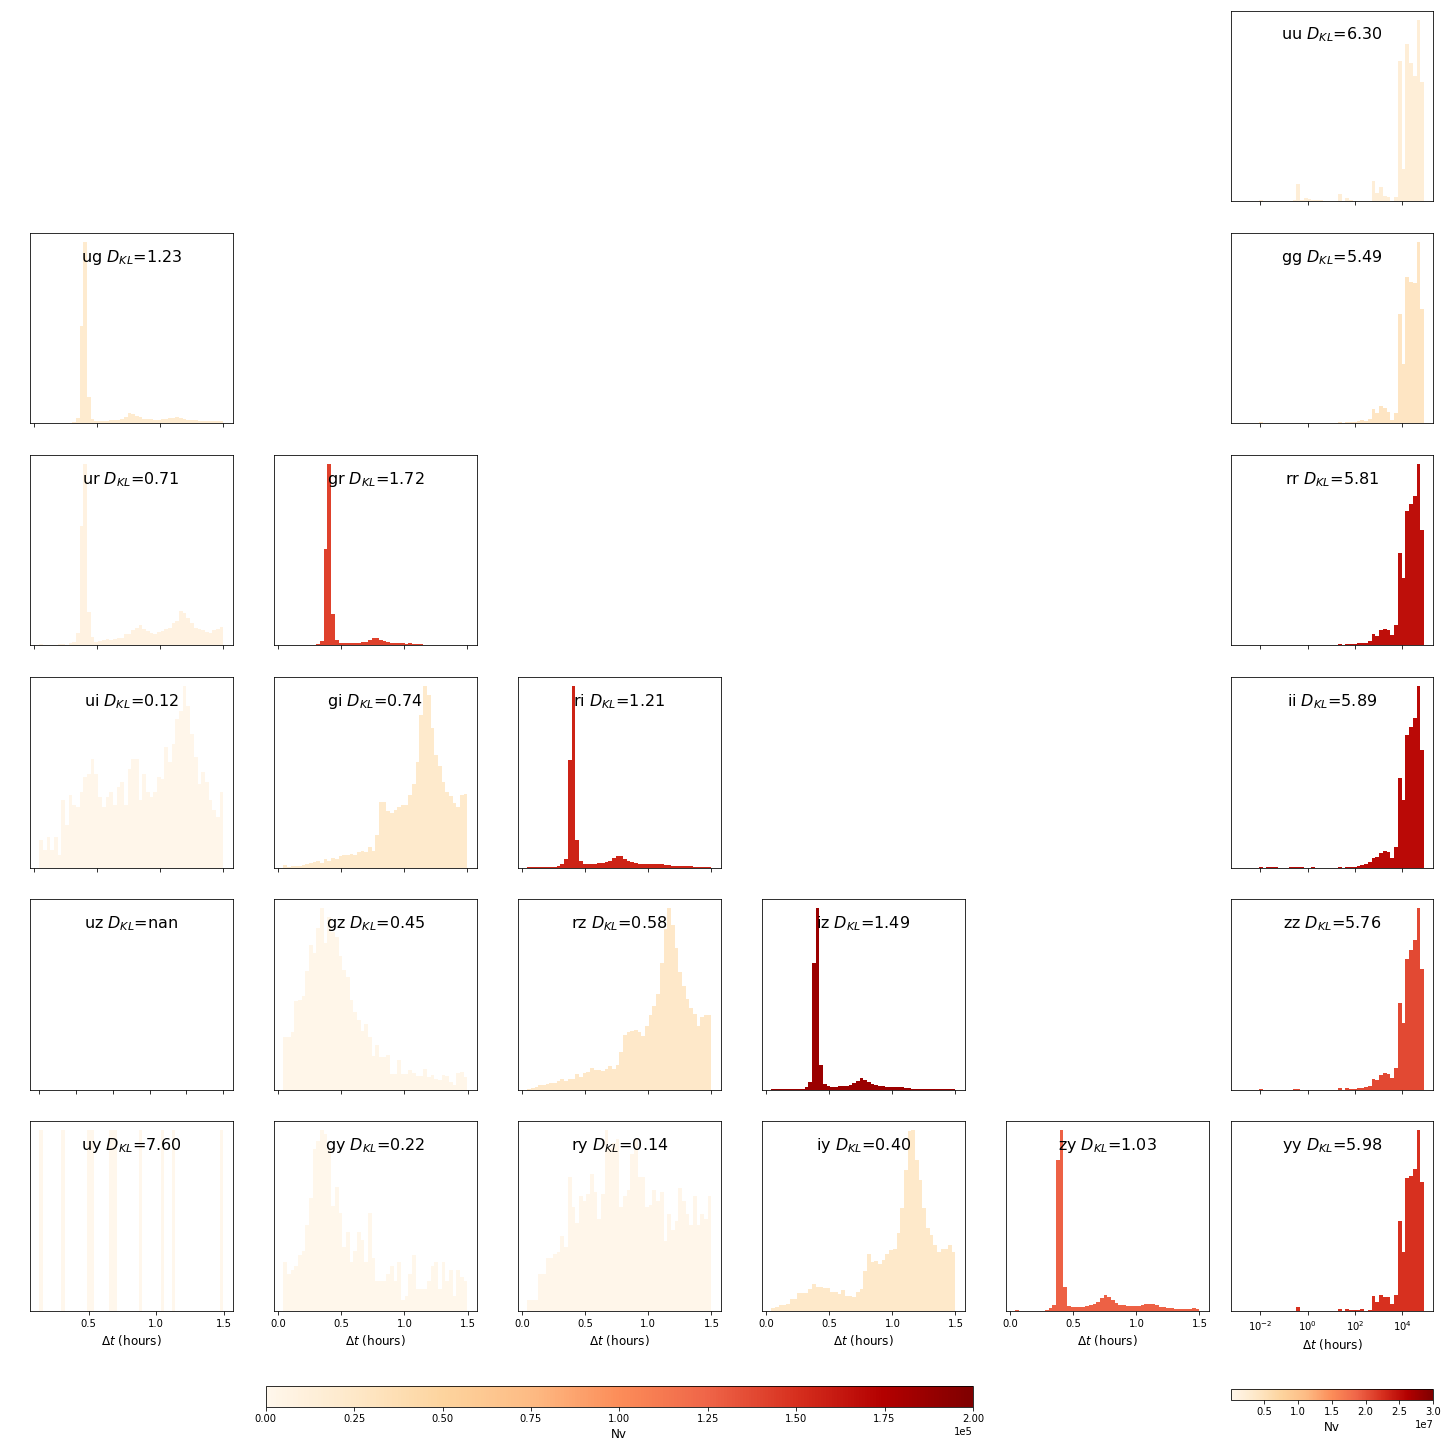

In [115]:
plot_hist_colorbar(filter_dict, figsize=(20, 20), histbins=[bins_log, 50], cumulative=False, density=False, histtype='stepfilled')


Text(0, 0.5, 'Nv')

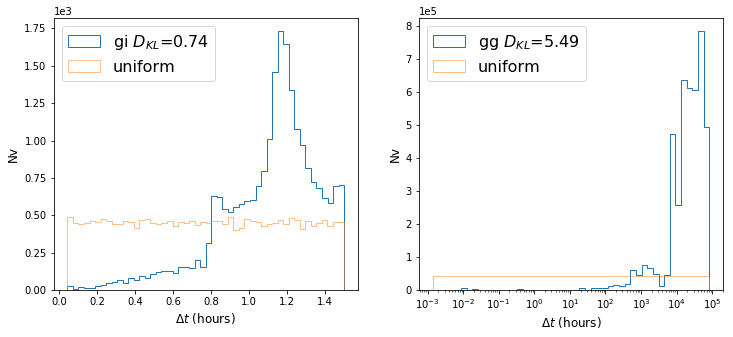

In [74]:
# plot a distribution with uniform one 

key = 'gi'
dT = filter_dict[key]['dT']
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

dkltex = '$D_{KL}$'
title = '{} {}={:.2f}'.format(key, dkltex, filter_dict[key] ['Dkl'])

uni = np.random.uniform(low=dT.min(), high=dT.max(), size=len(dT) )

ax = axs[0]
_ = ax.hist(dT, bins=50, label=title, 
                          cumulative=False, density=False, histtype='step' );
_ = ax.hist(uni, bins=50, label='uniform', alpha=0.5,
                          cumulative=False, density=False, histtype='step'  );
ax.legend(loc='upper left')
ax.set_xlabel('$\Delta t$ (hours)')
ax.set_ylabel('Nv')
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# --------------------------
key = 'gg'
dT = filter_dict[key]['dT']

low = np.log(dT.min())
high = np.log(dT.max())
uni = np.power(10, np.random.uniform(low=low, high=high, size=len(dT) ) )

title = '{} {}={:.2f}'.format(key, dkltex, filter_dict[key] ['Dkl'])

ax = axs[1]
_ = ax.hist(dT, bins=bins_log, label=title, 
                          cumulative=False, density=False, histtype='step' );

_ = ax.hist(uni, bins=bins_log, label='uniform', alpha=0.5,
                          cumulative=False, density=False, histtype='step'  );
ax.set_xscale('log')
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.legend(loc='upper left')
ax.set_xlabel('$\Delta t$ (hours)')
ax.set_ylabel('Nv')

# fig.suptitle(title)

In [64]:
def get_fom_Nv(filter_dict):
    '''get fom for each filter pair'''

    #filter_dict = get_hist_dict(dbfile=dbfile, path=path , night=night, 
    #             tmin=tmin, tmax=tmax, histbins=histbins)
    
    print('calculating FOM of {}...'.format( dbfile ) )

    flt = ['u', 'g', 'r', 'i', 'z', 'y']


    '''
    # get total Nvisits for normalization  
    N_total_same = 0
    N_total_diff = 0
    for i, f0 in enumerate(flt):
        for f1 in flt[i:]:
            key = '{}{}'.format(f0, f1)
            if f0==f1:
                
                N_total_same += len( filter_dict[key]['dT'] )
                
            else:
                
                N_total_diff += len( filter_dict[key]['dT'] )
                
    '''
    
    # calcuate figure of merit for each filter pair
    fom_dict = {}
    Nv_dict = {}
    for i, f0 in enumerate(flt):
        for f1 in flt[i:]:  
        
            key = '{}{}'.format(f0, f1)
            
            fom_dict[key] = filter_dict[key]['Nv'] * filter_dict[key]['eDkl']
            Nv_dict[key] = filter_dict[key]['Nv']
            # print(key, fom)

    return fom_dict, Nv_dict


In [66]:
fom_dict, Nv_dict = get_fom_Nv(filter_dict)

calculating FOM of tGaps_sat_dodge_v1.4_10yrs.db_nside16_note not like "DD%" _mag...


In [116]:
fom_dict.values()

dict_values([2532.4788077893136, 864.6873723620213, 1747.6571539120011, 1146.9221315285308, nan, 0.3049847871815915, 7436.641643274193, 28162.765045479468, 19627.492922700356, 2912.057292438587, 1247.6725161211687, 83988.97190614678, 51696.235510468214, 20487.97385512225, 3151.0667198746314, 71692.77618726846, 47138.5308351508, 7554.250142925676, 62487.26171076709, 5555.385357255137, 88500.11691980397])

In [114]:
fom_dict

{'uu': 2532.4788077893136,
 'ug': 864.6873723620213,
 'ur': 1747.6571539120011,
 'ui': 1146.9221315285308,
 'uz': nan,
 'uy': 0.3049847871815915,
 'gg': 7436.641643274193,
 'gr': 28162.765045479468,
 'gi': 19627.492922700356,
 'gz': 2912.057292438587,
 'gy': 1247.6725161211687,
 'rr': 83988.97190614678,
 'ri': 51696.235510468214,
 'rz': 20487.97385512225,
 'ry': 3151.0667198746314,
 'ii': 71692.77618726846,
 'iz': 47138.5308351508,
 'iy': 7554.250142925676,
 'zz': 62487.26171076709,
 'zy': 5555.385357255137,
 'yy': 88500.11691980397}

In [107]:
cols = ['db', 'uu', 'ug', 'ur', 'ui', 'uz', 'uy', 'gg', 'gr', 'gi', 'gz', 'gy', 'rr', 'ri', 'rz', 'ry', 'ii', 'iz', 'iy', 'zz', 'zy', 'yy']

df_fom = pd.read_csv('tgaps_fom_v1.csv', names=cols, na_values=' nan')



In [113]:
df_fom.to_csv('tgaps_raw.csv', index=False)

footprint

In [67]:
def cal_Nv(df, tmin=[5/60/60, 5/60/60], tmax=[4000*24, 1.5]):
    '''
    select where dT meet requirements, i.e. within tmin~tmax
    tmin[0], tmax[0]for same filter, in hours
    tmin[0], tmax[1] for different filter, in hours
    '''
    if df['f0']==df['f1']:
        #use the number of visits as Nv
        
        Nv = len(df['t_f0'] [ df['t_f0'] < (59853.985644 + tmax[0]/24) ] )
    else:
        # use number of gaps as Nv
        dT_lim = df['dT'] [ (df['dT']>tmin[1])&(df['dT']<tmax[1]) ]
        Nv = len(dT_lim)
        
    return Nv


In [71]:
def get_df_new(df_Nv):
    # change format of dataframe, use filter pairs as columns 
    df_new = df_Nv[(df_Nv.f0=='u') & (df_Nv.f1=='u')].reset_index() [[ 'field', 'ra', 'dec' ]]
    flt = ['u', 'g', 'r', 'i', 'z', 'y']
    for i, f0 in enumerate(flt):
        for f1 in flt[i:]:
            #print(f0,f1)
            key = '{}{}'.format(f0, f1)
            df_new[key] = df_Nv[ (df_Nv.f0==f0) & (df_Nv.f1==f1) ]['Nv'].values
    return df_new
    

In [68]:
dbfile = 'tGaps_sat_dodge_v1.4_10yrs.db_nside16_note not like "DD%" _mag'
path = '/home/idies/workspace/Temporary/lixl/scratch/'

dbfile = path + dbfile

df_all = pd.read_csv(dbfile, 
         converters={'t_f0':to_array, 't_f1':to_array})

df_all['diffmat'] = df_all.apply(cal_diffmat, axis=1, night=[0, 4000]) # select all 10yrs nights
df_all['dT'] = df_all.apply(cal_dT, axis=1)
df_all['Nv'] = df_all.apply(cal_Nv, axis=1)


In [73]:
df_all.head(2)

,field,proposalId,ra,dec,f0,f1,t_f0,t_f1,fiveSigma_f0,fiveSigma_f1,diffmat,dT,Nv
0,1,29.444444,76.491854,34.268187,u,u,[],[],[],[],[],[],0
1,1,29.444444,76.491854,34.268187,u,g,[],[59962.07618867],[],[24.14568133],[],[],0


In [74]:
df_new = get_df_new(df_all)
df_new.head(2)

,field,ra,dec,uu,ug,ur,ui,uz,uy,gg,...,rr,ri,rz,ry,ii,iz,iy,zz,zy,yy
0,1,76.491854,34.268187,0,0,0,0,0,0,1,...,3,2,0,0,3,0,0,2,0,0
1,2,81.685793,34.228646,0,0,0,0,0,0,4,...,4,0,0,0,3,1,0,5,0,0


In [ ]:
fltpair_all = ['uu', 'ug', 'ur', 'ui', 'uz', 'uy', 'gg', 'gr', 'gi', 'gz', 'gy', 'rr', 'ri', 'rz', 'ry', 'ii', 'iz', 'iy', 'zz', 'zy', 'yy']

fltpair_same = ['uu', 'gg', 'rr', 'ii', 'zz', 'yy']

fltpair_diff = ['ug', 'ur', 'ui', 'uz', 'uy', 'gr', 'gi', 'gz', 'gy',  'ri', 'rz', 'ry', 'iz', 'iy', 'zy']


In [75]:
df_new

,field,ra,dec,uu,ug,ur,ui,uz,uy,gg,...,rr,ri,rz,ry,ii,iz,iy,zz,zy,yy
0,1,76.491854,34.268187,0,0,0,0,0,0,1,...,3,2,0,0,3,0,0,2,0,0
1,2,81.685793,34.228646,0,0,0,0,0,0,4,...,4,0,0,0,3,1,0,5,0,0
2,3,87.438398,34.278001,0,0,0,0,0,0,2,...,4,3,0,0,8,1,0,1,0,0
3,4,92.632944,34.370001,0,0,0,0,0,0,0,...,1,0,0,0,2,2,0,2,0,0
4,5,98.341276,34.171152,0,0,0,0,0,0,0,...,0,0,0,0,2,2,0,5,0,0
5,6,103.250521,34.225484,0,0,0,0,0,0,0,...,3,2,0,0,3,1,0,1,0,0
6,7,296.587326,34.964417,5,0,0,0,0,0,0,...,1,0,0,0,1,1,0,2,0,8
7,8,299.526838,34.831209,2,0,0,0,0,0,1,...,3,1,0,0,5,6,0,6,0,6
8,9,57.626307,31.566234,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
9,10,62.534000,31.803738,0,0,0,0,0,0,3,...,5,2,0,0,6,3,0,6,0,0


In [87]:
from lsst.utils import getPackageDir
from scipy.interpolate import interp1d
from lsst.sims.maf.utils import radec2pix

def load_starmap(flt='r'):
    # get mapdir '/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maps/2017.05.08-4-gac432e6/StarMaps'
    mapDir = os.path.join(getPackageDir('sims_maps'),'StarMaps') 

    mapfile = 'starDensity_{}_nside_64.npz'.format(flt)

    starMap = np.load( os.path.join(mapDir, mapfile) )
    
    return starMap
    
    
def get_starDensity(ra=0, dec=0, starMap=None, mag=25):
    '''get star density of a field, from star density map,
    input ra, dec in degree 
    returns stars / (sq degree)
    '''
    ra = ra * np.pi / 180   # convert to radian
    dec = dec * np.pi / 180

    starMapDensity = starMap['starDensity'].copy()
    starMapBins = starMap['bins'].copy()
    starmapNside = hp.npix2nside( np.size(starMapDensity[:,0]) )
    
    ipix = radec2pix(starmapNside, ra, dec) # convert from ra/dec to ipix 
    density = interp1d( starMapBins[1:], starMapDensity[ipix, :] ) (mag)
    return int( density )


In [93]:
def get_density(df, starmap=None):
    den = get_starDensity( ra=df['ra'], dec=df['dec'], starMap=starmap)
    print(df['field'], den)

    return den


In [88]:
starmap = load_starmap(flt='r')


In [91]:
df_new.columns

Index(['field', 'ra', 'dec', 'uu', 'ug', 'ur', 'ui', 'uz', 'uy', 'gg', 'gr',
       'gi', 'gz', 'gy', 'rr', 'ri', 'rz', 'ry', 'ii', 'iz', 'iy', 'zz', 'zy',
       'yy'],
      dtype='object')

In [96]:
df_new['density'] = df_new.apply(get_density, axis=1, starmap=starmap)

1.0 70488
2.0 141876
3.0 51696
4.0 37872
5.0 25020
6.0 19296
7.0 253764
8.0 148788
9.0 17928
10.0 21348
11.0 27252
12.0 34776
13.0 72720
14.0 57132
15.0 50292
16.0 32364
17.0 22644
18.0 16812
19.0 12672
20.0 10764
21.0 9432
22.0 307872
23.0 437904
24.0 126072
25.0 11304
26.0 13716
27.0 14040
28.0 20628
29.0 21132
30.0 43308
31.0 79956
32.0 104688
33.0 41292
34.0 30528
35.0 21528
36.0 13536
37.0 11520
38.0 10008
39.0 8028
40.0 6660
41.0 503676
42.0 358776
43.0 312264
44.0 9900
45.0 9180
46.0 11088
47.0 12852
48.0 15876
49.0 14904
50.0 25236
51.0 39564
52.0 74556
53.0 86400
54.0 40644
55.0 28548
56.0 18324
57.0 13536
58.0 12420
59.0 9036
60.0 8280
61.0 6588
62.0 6300
63.0 434340
64.0 647028
65.0 269568
66.0 8280
67.0 8100
68.0 10116
69.0 9144
70.0 10188
71.0 13068
72.0 14544
73.0 12744
74.0 25704
75.0 35172
76.0 128880
77.0 60084
78.0 38376
79.0 23796
80.0 18612
81.0 12996
82.0 10980
83.0 8208
84.0 6876
85.0 7416
86.0 6048
87.0 5688
88.0 342756
89.0 378720
90.0 383616
91.0 8064
92.0 9000

In [99]:
def get_Nf(df=None, fltpair=['rr'], Nth=0):
    
    '''return number of fields that have visits >= Nth
       fltpair: single filter pair or a list of filter pairs
    '''
    idx = np.sum (df[fltpair], axis=1) >= Nth
    Nf = df[fltpair] [ idx ].shape[0]
    Nstar = np.sum( df['density'].values [idx] )
    
    return Nf, Nstar


In [100]:
# use the median of baseline as threshold
Nv_thdic = {'uu':58, 'ug':27, 'ur':22, 'ui':10, 'uz':1, 'uy':1, 
         'gg':80, 'gr':122, 'gi':38, 'gz':17, 'gy':5, 
         'rr':192, 'ri':161, 'rz':50, 'ry':17, 
         'ii': 193, 'iz':177, 'iy':61, 
         'zz':174, 'zy':156, 
         'yy':181 }

In [120]:
cols = ['uu', 'ug', 'ur', 'ui', 'uz', 'uy', 'gg', 'gr', 'gi', 'gz', 'gy',
        'rr', 'ri', 'rz', 'ry', 'ii', 'iz', 'iy', 'zz', 'zy', 'yy']


In [123]:
print( data )

[628, 51787800, 7, 739080, 453, 21810024, 785, 49275648, 941, 122015520, 110, 1564344, 438, 34776792, 614, 45810072, 820, 61010388, 693, 63545832, 731, 94302216, 743, 50243364, 823, 62175528, 848, 57390120, 599, 56568024, 528, 40862664, 54, 4450608, 51, 829368, 956, 61595604, 48, 9081468, 645, 47841516]


In [121]:
data = []
for c in cols:
    Nf, Nstar = get_Nf(df=df_new, fltpair=[c], Nth=Nv_thdic[c] )
    data.append(Nf)
    data.append(Nstar)
    print(c, Nf, Nstar)
    

uu 628 51787800
ug 7 739080
ur 453 21810024
ui 785 49275648
uz 941 122015520
uy 110 1564344
gg 438 34776792
gr 614 45810072
gi 820 61010388
gz 693 63545832
gy 731 94302216
rr 743 50243364
ri 823 62175528
rz 848 57390120
ry 599 56568024
ii 528 40862664
iz 54 4450608
iy 51 829368
zz 956 61595604
zy 48 9081468
yy 645 47841516


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/matplotlib/projections/geo.py:421: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


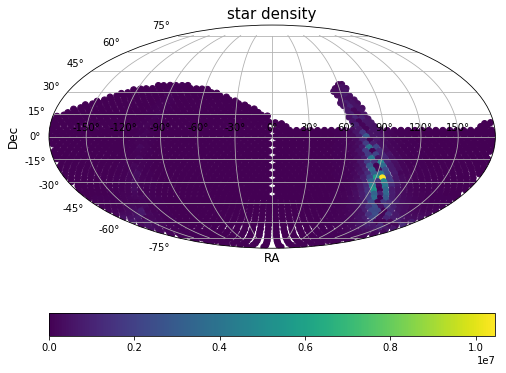

In [98]:
x = df_new['ra']
y = df_new['dec']
c = df_new['density']

fig, ax = plt.subplots(1, 1, figsize=(8, 8), 
                            subplot_kw={'projection': 'mollweide'}); 
plot_mwd(ax, x, y, c, title='star density') 

In [97]:
def plot_mwd(ax, RA, Dec, c, org=0, title='Mollweide projection', projection='mollweide', vmax=None, **kwargs):
    ''' RA, Dec are arrays of the same length.
    RA takes values in [0,360), Dec in [-90,90],
    which represent angles in degrees.
    org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    title is the title of the figure.
    projection is the kind of projection: 'mollweide', 'aitoff', 'hammer', 'lambert'
    
    Examples:
    >>> fig, ax = plt.subplots(1, 1, figsize=(8, 8), 
                            subplot_kw={'projection': 'mollweide'}); 
        plot_mwd(ax, x, y, c, title='') 
    '''
    if vmax is None:
        vmax = c.max()
    
    x = np.remainder(RA+360-org,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    # fig = plt.figure(figsize=(10, 5))
    # ax = fig.add_subplot(111, projection=projection, facecolor ='LightCyan')
    # ax = fig.add_subplot(111, projection=projection, facecolor ='honeydew')
    sc = ax.scatter(np.radians(x), np.radians(Dec), c=c, marker='o', vmin=0, vmax=vmax, **kwargs)  # convert degrees to radians
    # ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    ax.set_title(title)
    ax.title.set_fontsize(15)
    ax.set_xlabel("RA")
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel("Dec")
    ax.yaxis.label.set_fontsize(12)
    ax.grid(True)
    cbar = plt.colorbar(sc, ax=ax, orientation="horizontal")
    #cbar.set_clim(-2.0, 2.0)
